# getting started

In [1]:
#reading in data
# %load_ext autoreload
# %autoreload 2
import IPython
print(IPython.get_ipython().config)
import os
os.getcwd()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
import requests
import json
import sys
import os
import pickle

project_root = os.path.abspath(os.path.join(os.getcwd(), '../../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

#functions written by AK:
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.filtering_functions import *
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.graphing_fxns import *
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.making_cellbox_files import *
from Abdullah_kuziez.preprocessing.pre_processing_py_fxns.Initial_structuring import *

{'IPKernelApp': {'connection_file': 'c:\\Users\\abdul\\AppData\\Roaming\\jupyter\\runtime\\kernel-v31a293ae31cccd25d79c3e9f198ba14e743c94684.json'}, 'Completer': {'use_jedi': False}}


In [2]:
intermediate_dir_48hr = Path("intermediate_files_TNBC/48hr")
data_48hr=load_data(intermediate_dir_48hr, "48hr")
intermediate_dir_6hr = Path("intermediate_files_TNBC/6hr")
data_6hr=load_data(intermediate_dir_6hr, "6hr")
intermediate_dir_24hr = Path("intermediate_files_TNBC/24hr")
data_24hr=load_data(intermediate_dir_24hr, "24hr")

#splitting the data into targeted and non_targeted proteins:
all_targeted_prots=[item for sublist in data_48hr['drug_pert_id_targets_dict'].values() for item in sublist]

targeted_prots_raw_6hr,targeted_prots_raw_24hr,targeted_prots_raw_48hr={},{},{}
non_targeted_prots_raw_6hr,non_targeted_prots_raw_24hr,non_targeted_prots_raw_48hr={},{},{}
cell_lines=data_48hr['cell_lines']
for cell in cell_lines:
    meta_cols_48hr=data_48hr['data_by_cell_line_raw'][cell].columns[data_48hr['data_by_cell_line_raw'][cell].columns.str.contains('meta_')]
    meta_cols_6hr=data_6hr['data_by_cell_line_raw'][cell].columns[data_6hr['data_by_cell_line_raw'][cell].columns.str.contains('meta_')]
    meta_cols_24hr=data_24hr['data_by_cell_line_raw'][cell].columns[data_24hr['data_by_cell_line_raw'][cell].columns.str.contains('meta_')]

    intersection_48hr=list(set(all_targeted_prots).intersection(set(data_48hr['data_by_cell_line_raw'][cell].columns)))
    intersection_6hr=list(set(all_targeted_prots).intersection(set(data_6hr['data_by_cell_line_raw'][cell].columns)))
    intersection_24hr=list(set(all_targeted_prots).intersection(set(data_24hr['data_by_cell_line_raw'][cell].columns)))


    targeted_prots_raw_48hr[cell] = data_48hr['data_by_cell_line_raw'][cell][list(intersection_48hr) + list(meta_cols_48hr)]
    targeted_prots_raw_6hr[cell] = data_6hr['data_by_cell_line_raw'][cell][list(intersection_6hr) + list(meta_cols_6hr)]
    targeted_prots_raw_24hr[cell] = data_24hr['data_by_cell_line_raw'][cell][list(intersection_24hr) + list(meta_cols_24hr)]
    
    non_targeted_prots_raw_48hr[cell]=data_48hr['data_by_cell_line_raw'][cell].drop(columns=intersection_48hr)
    non_targeted_prots_raw_6hr[cell]=data_6hr['data_by_cell_line_raw'][cell].drop(columns=intersection_6hr)
    non_targeted_prots_raw_24hr[cell]=data_24hr['data_by_cell_line_raw'][cell].drop(columns=intersection_24hr)

In [ ]:
#pipeline setup for all timepoints
saved_filter_dir=r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\preprocessing\TNBC_notebooks\filtering_results'
pipeline_steps_tgt=[['filter_proteins_with_control', '_'],
                ['log2_transform_by_control', '_'],
                ['filter_incomplete_proteins', '.95'],
                ['filter_incomplete_experiments', '.95'],
                ['fill_na_with_mean', '_'],
                ['filter_keep_low_cv', '.8'],
                # ['remove_outlier_proteins', '10'],
                ['filter_by_mutual_information', '.001','meta_Inhi_5'],
                # ['iterative_signal_filtering', '2.5'],
                # ['spearman_corr_filtering', '0.2','meta_Inhi_5'],
                # ['pearson_corr_filtering', '0.2','meta_Inhi_5']
                ]

pipeline_steps_nontgt=[['filter_proteins_with_control', '_'],
                ['log2_transform_by_control', '_'],
                ['filter_incomplete_proteins', '.95'],
                ['filter_incomplete_experiments', '.95'],
                ['fill_na_with_mean', '_'],
                # ['filter_keep_low_cv', '.8'],
                # ['remove_outlier_proteins', '10'],
                ['filter_by_mutual_information', '.05','meta_Inhi_5'],
                ['iterative_signal_filtering', '2.5'],
                ['spearman_corr_filtering', '0.2','meta_Inhi_5'],
                ['pearson_corr_filtering', '0.2','meta_Inhi_5']
                ]
config={'print_flag':False,'graph_flag':False,'graph_type':'hist','filter_flag':True,'verbose':True}
#//////////LOO regression////////////////////////////
from sklearn.linear_model import ElasticNetCV

elasticnet_model= ElasticNetCV(
    alphas=[0.001, 0.01, 0.1, 1.0, 10.0],           # Alpha values to scan
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],            # L1 ratio values to scan
    cv=5,                                            # 5-fold CV for parameter selection
    random_state=42,
    max_iter=5000
)

targeted proteins 6hr
applying filter 1 of 7: ['filter_proteins_with_control', '_']
filtering proteins with control values
applying filter 2 of 7: ['log2_transform_by_control', '_']
log2 transforming by control
applying filter 3 of 7: ['filter_incomplete_proteins', '.95']
filtering incomplete proteins
applying filter 4 of 7: ['filter_incomplete_experiments', '.95']
filtering incomplete experiments
applying filter 5 of 7: ['fill_na_with_mean', '_']
filling na with mean
applying filter 6 of 7: ['filter_keep_low_cv', '.8']
filtering low coefficient of variation proteins
applying filter 7 of 7: ['filter_by_mutual_information', '.001', 'meta_Inhi_5']
filtering by mutual information
+---------------+---------+----------+---------+----------+--------+--------------+
|               |   BT549 |   DU4475 |   HCC70 |   HS578T |   MCF7 |   MDA-MB-453 |
+===============+=========+==========+=========+==========+========+==============+
| original_data |      70 |       70 |      70 |       70 |   

Processing cell lines:  17%|█▋        | 1/6 [00:07<00:39,  7.92s/it]

[HS578T] LOO R2: 0.500 | MSE: 0.064 | Pearson: 0.724 | Features: 134


Processing cell lines:  33%|███▎      | 2/6 [00:13<00:26,  6.72s/it]

[HCC70] LOO R2: 0.295 | MSE: 0.209 | Pearson: 0.587 | Features: 75


Processing cell lines:  50%|█████     | 3/6 [00:37<00:43, 14.61s/it]

[BT549] LOO R2: 0.598 | MSE: 0.123 | Pearson: 0.782 | Features: 198


Processing cell lines:  67%|██████▋   | 4/6 [00:47<00:25, 12.53s/it]

[MDA-MB-453] LOO R2: 0.397 | MSE: 0.853 | Pearson: 0.631 | Features: 75


Processing cell lines:  83%|████████▎ | 5/6 [00:50<00:09,  9.11s/it]

[MCF7] LOO R2: -0.028 | MSE: 0.291 | Pearson: -0.025 | Features: 15


Processing cell lines: 100%|██████████| 6/6 [00:54<00:00,  9.10s/it]


[DU4475] LOO R2: 0.313 | MSE: 0.564 | Pearson: 0.575 | Features: 27


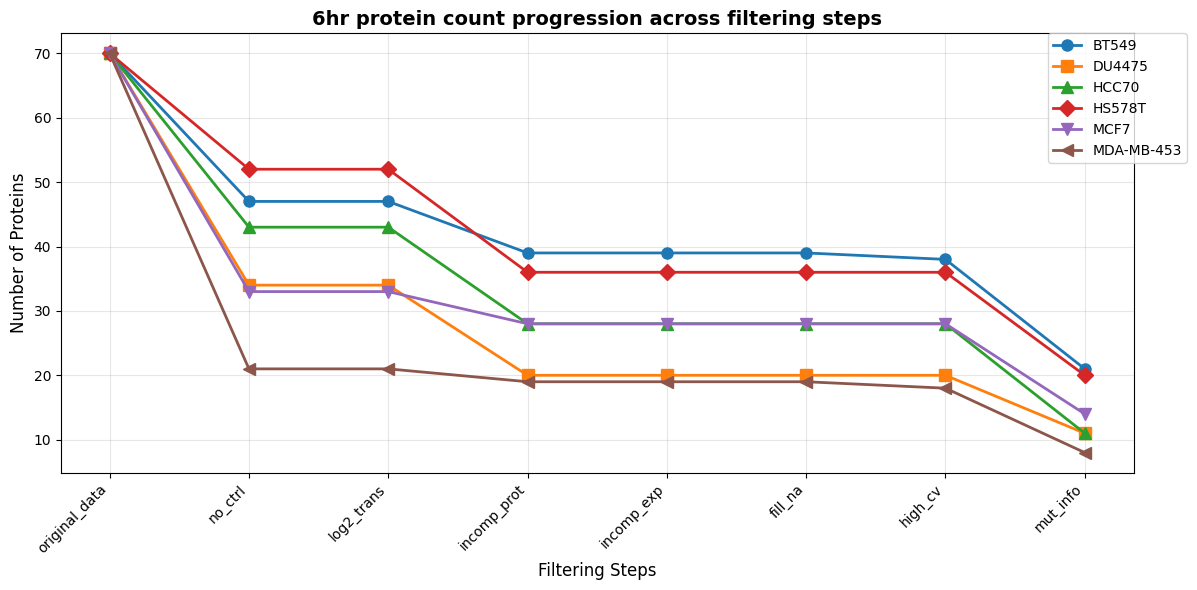

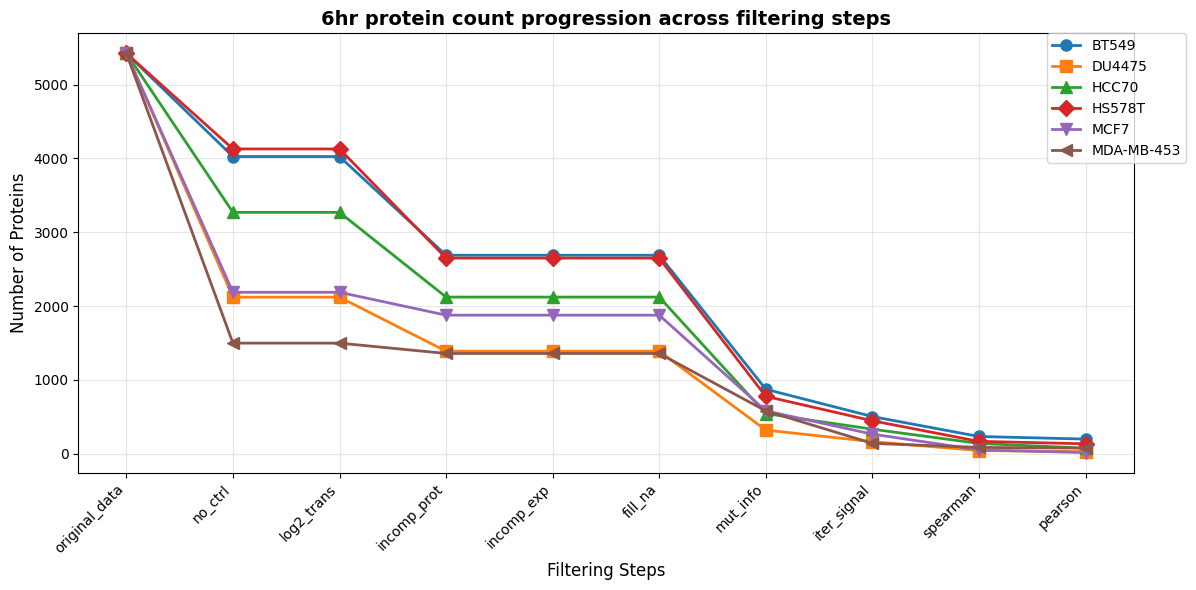

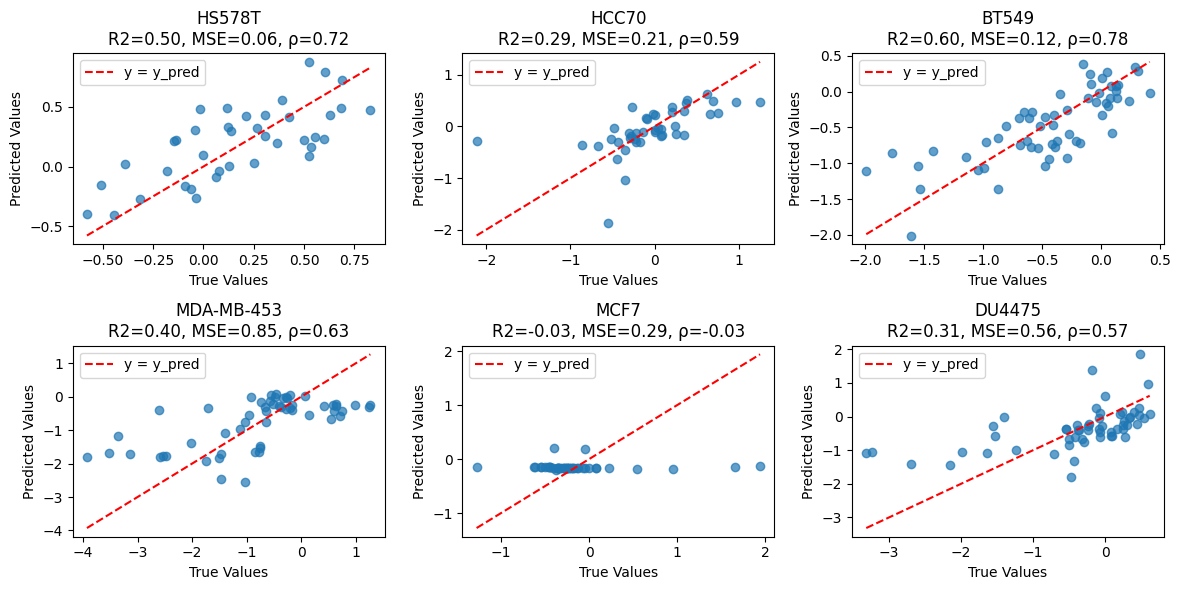

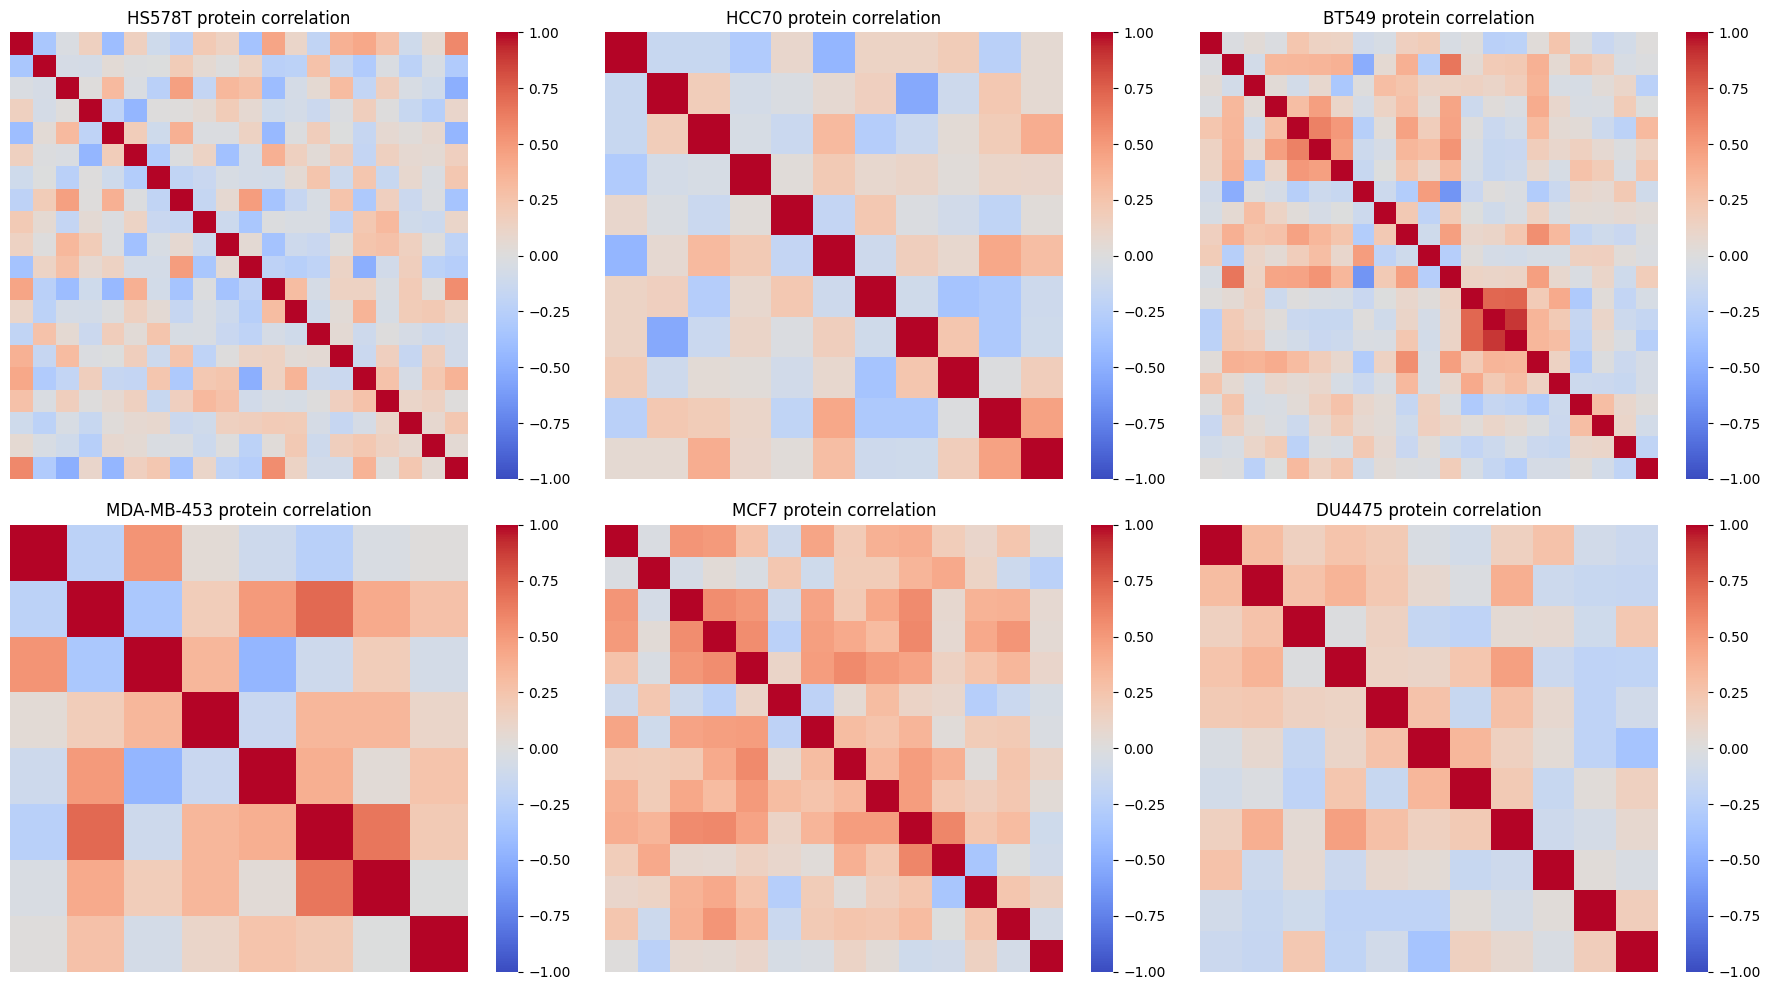

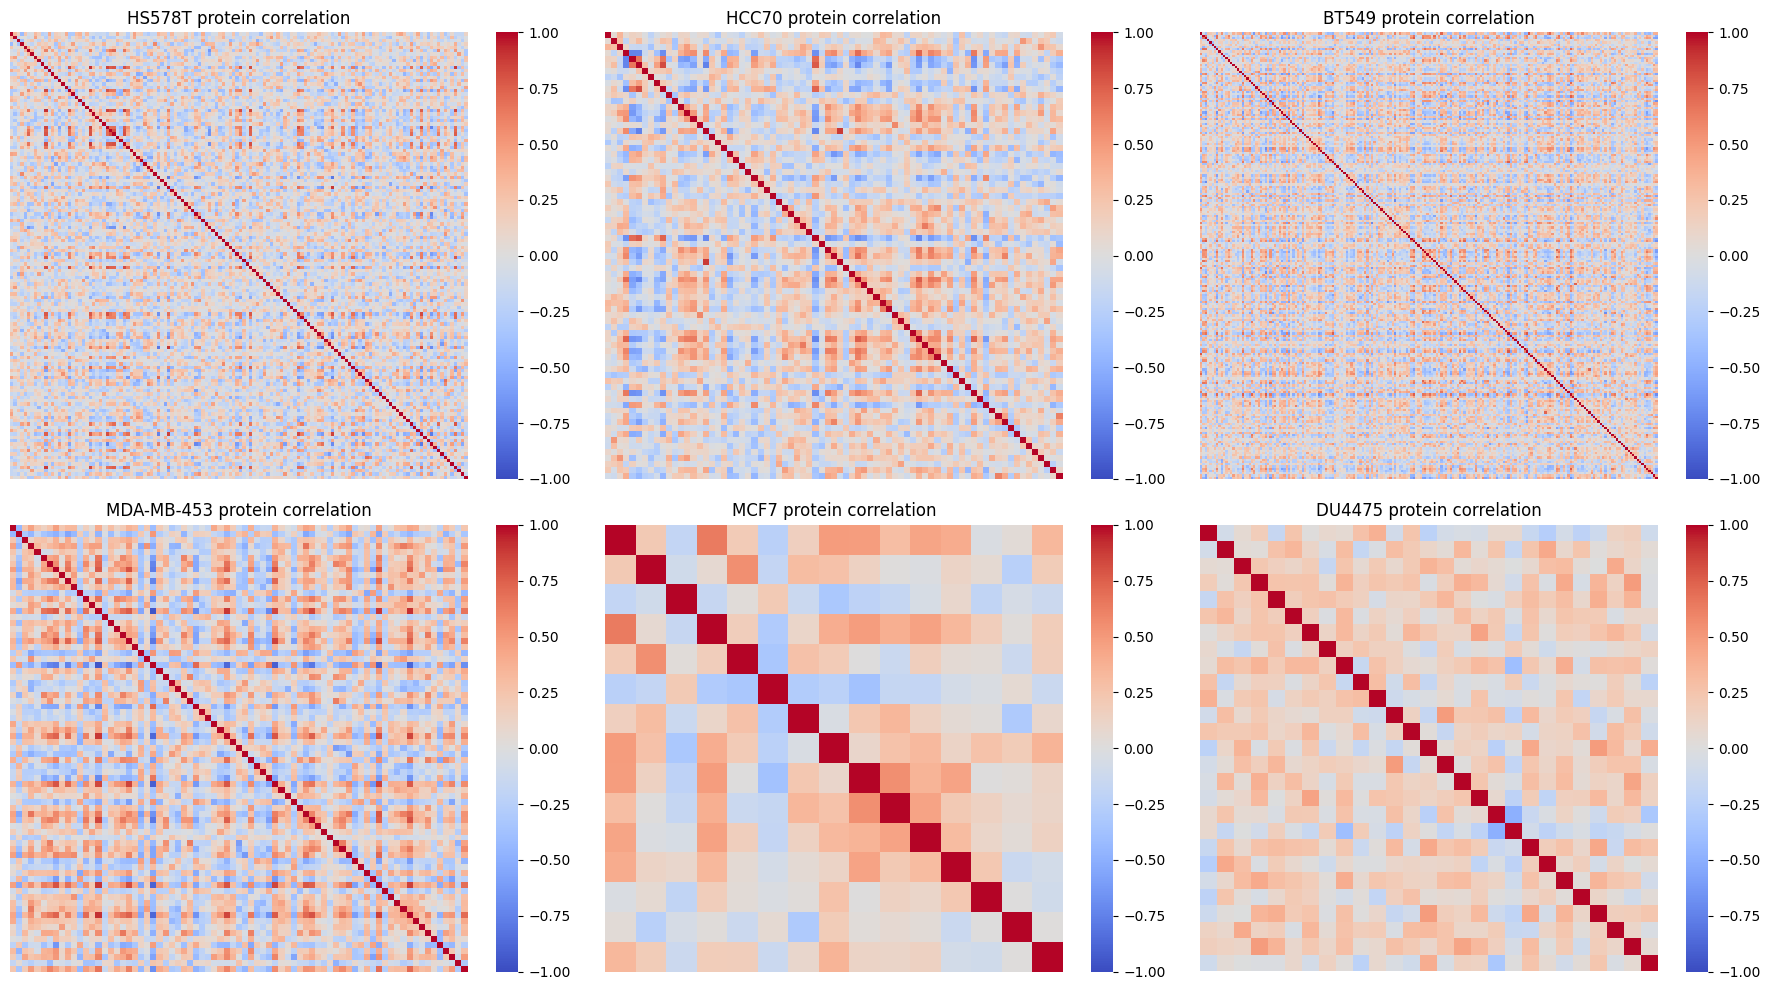

In [4]:
#6hr pipeline
print('targeted proteins 6hr')
six_hr_tgt_pipeline=filtering_pipeline(targeted_prots_raw_6hr,data_6hr['cell_lines'],data_6hr['control_data_by_cell_line'],'6hr',data_6hr['control_data_by_cell_line_coeffvar'],**config)
hd_six_tgt=six_hr_tgt_pipeline.run_pipeline(pipeline_steps_tgt)
sum_six_tgt=six_hr_tgt_pipeline.summary_of_pipeline()
six_hr_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='tgt')

print('non-targeted proteins 6hr')
six_hr_non_tgt_pipeline=filtering_pipeline(non_targeted_prots_raw_6hr,data_6hr['cell_lines'],data_6hr['control_data_by_cell_line'],'6hr',data_6hr['control_data_by_cell_line_coeffvar'],**config)
hd_six_non_tgt=six_hr_non_tgt_pipeline.run_pipeline(pipeline_steps_nontgt)
sum_six_non_tgt=six_hr_non_tgt_pipeline.summary_of_pipeline()
six_hr_non_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='nontgt')

loo_results = loo_regression_per_cell_line(
    data_by_cell_line=six_hr_non_tgt_pipeline.final_filtered_data,
    cell_lines=cell_lines,
    ycol='meta_Inhi_5',
    model=elasticnet_model,
    print_stats=True,
    plot_results=True,
    show_progress=True)

plot_protein_correlation_heatmaps(six_hr_tgt_pipeline.final_filtered_data,cell_lines)
plot_protein_correlation_heatmaps(six_hr_non_tgt_pipeline.final_filtered_data,cell_lines)

In [ ]:
#24hr pipeline:
print('targeted proteins 24hr')
twenty_four_hr_tgt_pipeline=filtering_pipeline(targeted_prots_raw_24hr,data_24hr['cell_lines'],data_24hr['control_data_by_cell_line'],'24hr',data_24hr['control_data_by_cell_line_coeffvar'],**config)
hd_twentyfour_tgt=twenty_four_hr_tgt_pipeline.run_pipeline(pipeline_steps_tgt)
sum_twentyfour_tgt=twenty_four_hr_tgt_pipeline.summary_of_pipeline()
twenty_four_hr_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='tgt')

print('non-targeted proteins 24hr')
twenty_four_hr_non_tgt_pipeline=filtering_pipeline(non_targeted_prots_raw_24hr,data_24hr['cell_lines'],data_24hr['control_data_by_cell_line'],'24hr',data_24hr['control_data_by_cell_line_coeffvar'],**config)
hd_twentyfour_non_tgt=twenty_four_hr_non_tgt_pipeline.run_pipeline(pipeline_steps_nontgt)
sum_twentyfour_non_tgt=twenty_four_hr_non_tgt_pipeline.summary_of_pipeline()
twenty_four_hr_non_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='nontgt')

loo_results = loo_regression_per_cell_line(
    data_by_cell_line=twenty_four_hr_non_tgt_pipeline.final_filtered_data,
    cell_lines=cell_lines,
    ycol='meta_Inhi_5',
    model=elasticnet_model,
    print_stats=True,
    plot_results=True,
    show_progress=True)

plot_protein_correlation_heatmaps(twenty_four_hr_tgt_pipeline.final_filtered_data,cell_lines)
plot_protein_correlation_heatmaps(twenty_four_hr_non_tgt_pipeline.final_filtered_data,cell_lines)

targeted proteins 48hr
applying filter 1 of 7: ['filter_proteins_with_control', '_']
filtering proteins with control values
applying filter 2 of 7: ['log2_transform_by_control', '_']
log2 transforming by control
applying filter 3 of 7: ['filter_incomplete_proteins', '.95']
filtering incomplete proteins
applying filter 4 of 7: ['filter_incomplete_experiments', '.95']
filtering incomplete experiments
applying filter 5 of 7: ['fill_na_with_mean', '_']
filling na with mean
applying filter 6 of 7: ['filter_keep_low_cv', '.8']
filtering low coefficient of variation proteins
applying filter 7 of 7: ['filter_by_mutual_information', '.001', 'meta_Inhi_5']
filtering by mutual information
+---------------+---------+----------+---------+----------+--------+--------------+
|               |   BT549 |   DU4475 |   HCC70 |   HS578T |   MCF7 |   MDA-MB-453 |
+===============+=========+==========+=========+==========+========+==============+
| original_data |      70 |       70 |      70 |       70 |  

Processing cell lines:   0%|          | 0/6 [00:00<?, ?it/s]c:\Users\abdul\.conda\envs\cellbox\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e-03, tolerance: 4.258e-04
  model = cd_fast.enet_coordinate_descent(
Processing cell lines:  17%|█▋        | 1/6 [00:31<02:35, 31.14s/it]

[HS578T] LOO R2: 0.296 | MSE: 0.093 | Pearson: 0.559 | Features: 234


Processing cell lines:  33%|███▎      | 2/6 [00:44<01:22, 20.58s/it]

[HCC70] LOO R2: -0.075 | MSE: 1.122 | Pearson: -0.100 | Features: 91


Processing cell lines:  50%|█████     | 3/6 [02:50<03:26, 68.89s/it]

[BT549] LOO R2: 0.407 | MSE: 0.173 | Pearson: 0.648 | Features: 212


Processing cell lines:  67%|██████▋   | 4/6 [02:59<01:30, 45.11s/it]

[MDA-MB-453] LOO R2: 0.424 | MSE: 0.815 | Pearson: 0.664 | Features: 51


Processing cell lines:  83%|████████▎ | 5/6 [03:02<00:30, 30.06s/it]

[MCF7] LOO R2: 0.081 | MSE: 0.277 | Pearson: 0.413 | Features: 21


Processing cell lines: 100%|██████████| 6/6 [03:16<00:00, 32.79s/it]


[DU4475] LOO R2: 0.268 | MSE: 0.592 | Pearson: 0.519 | Features: 57


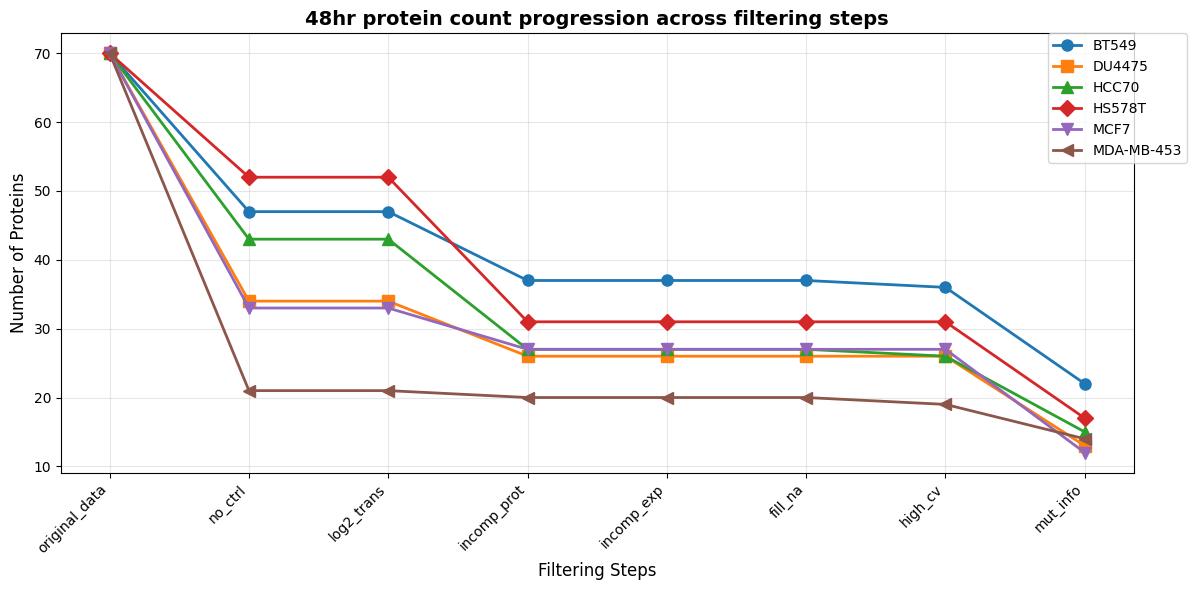

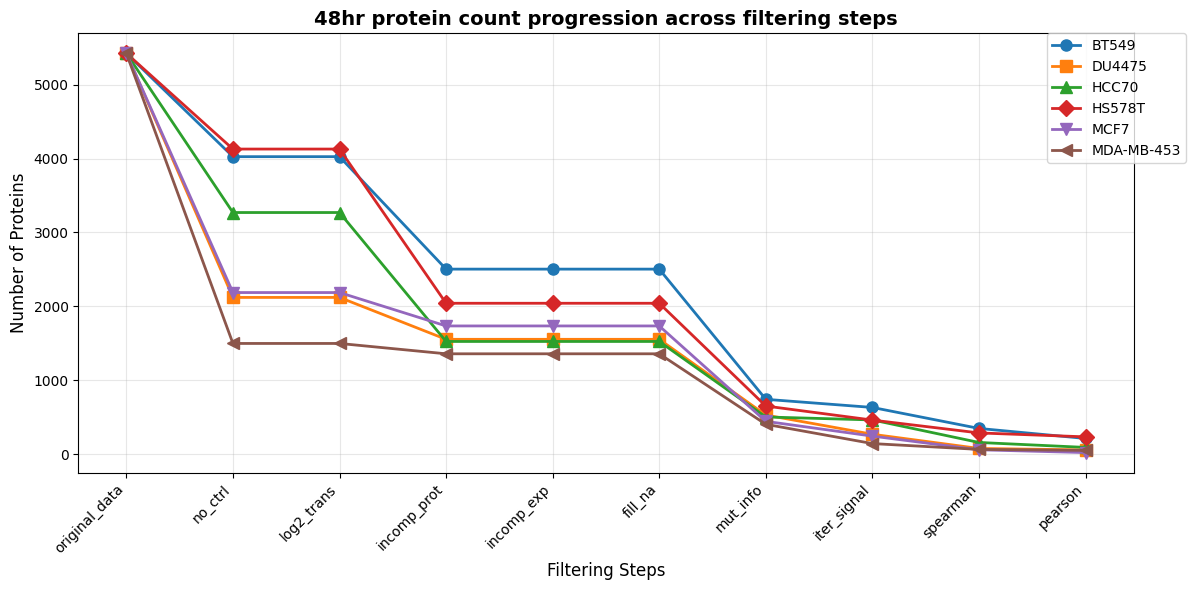

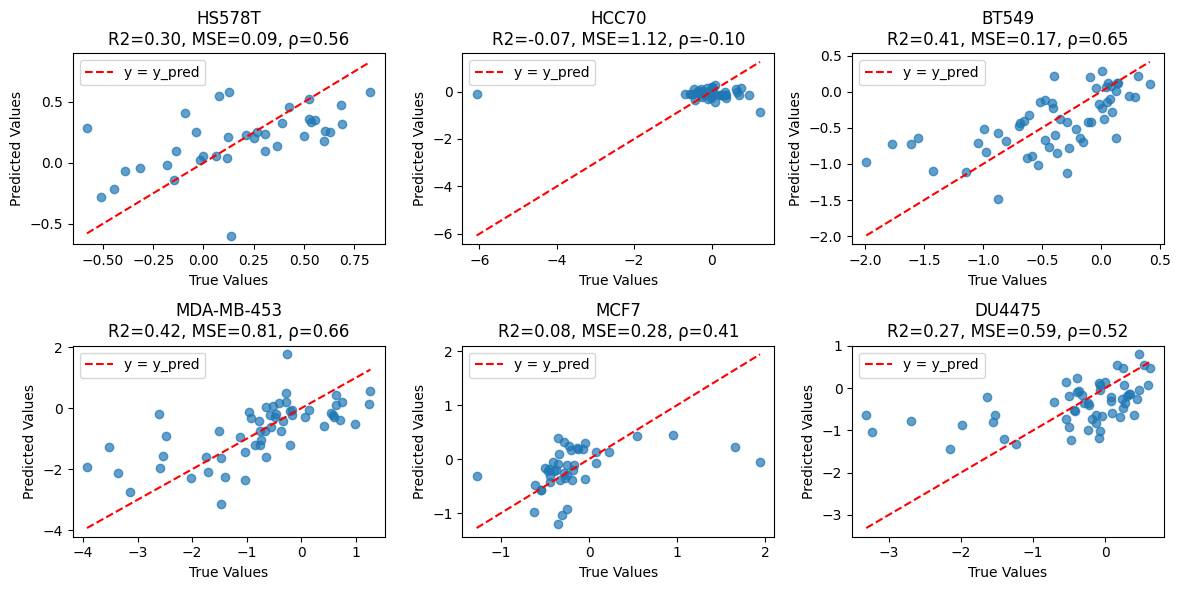

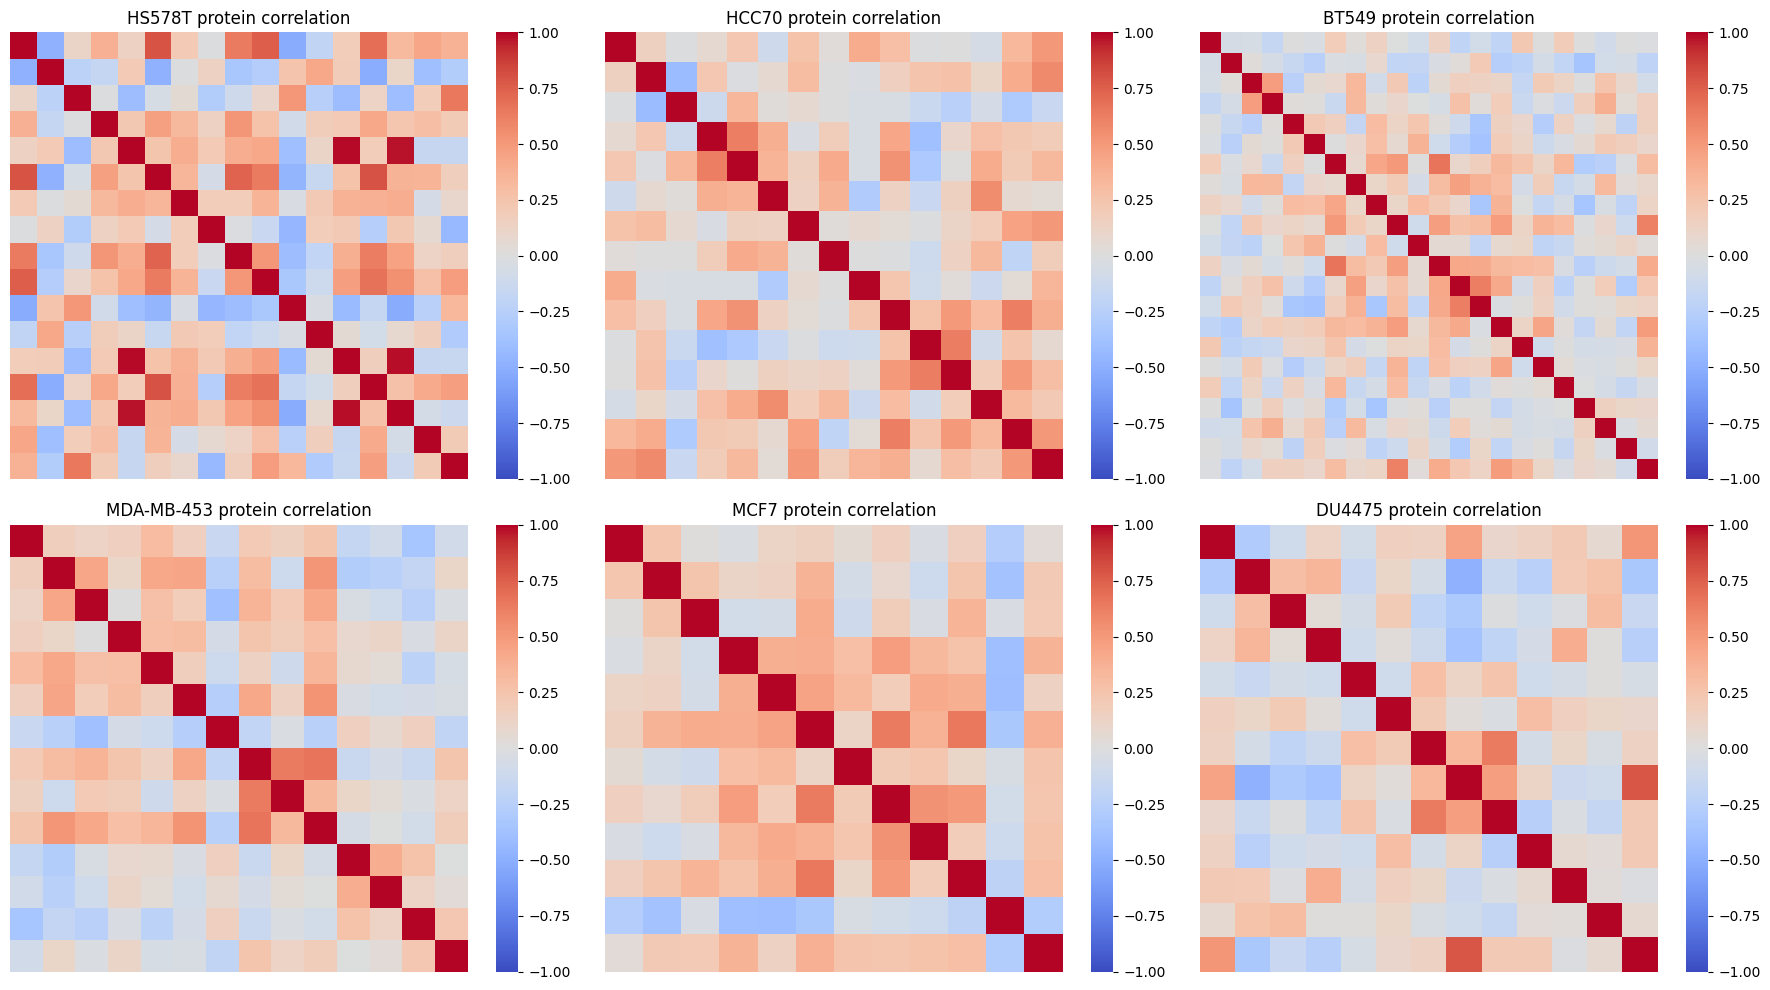

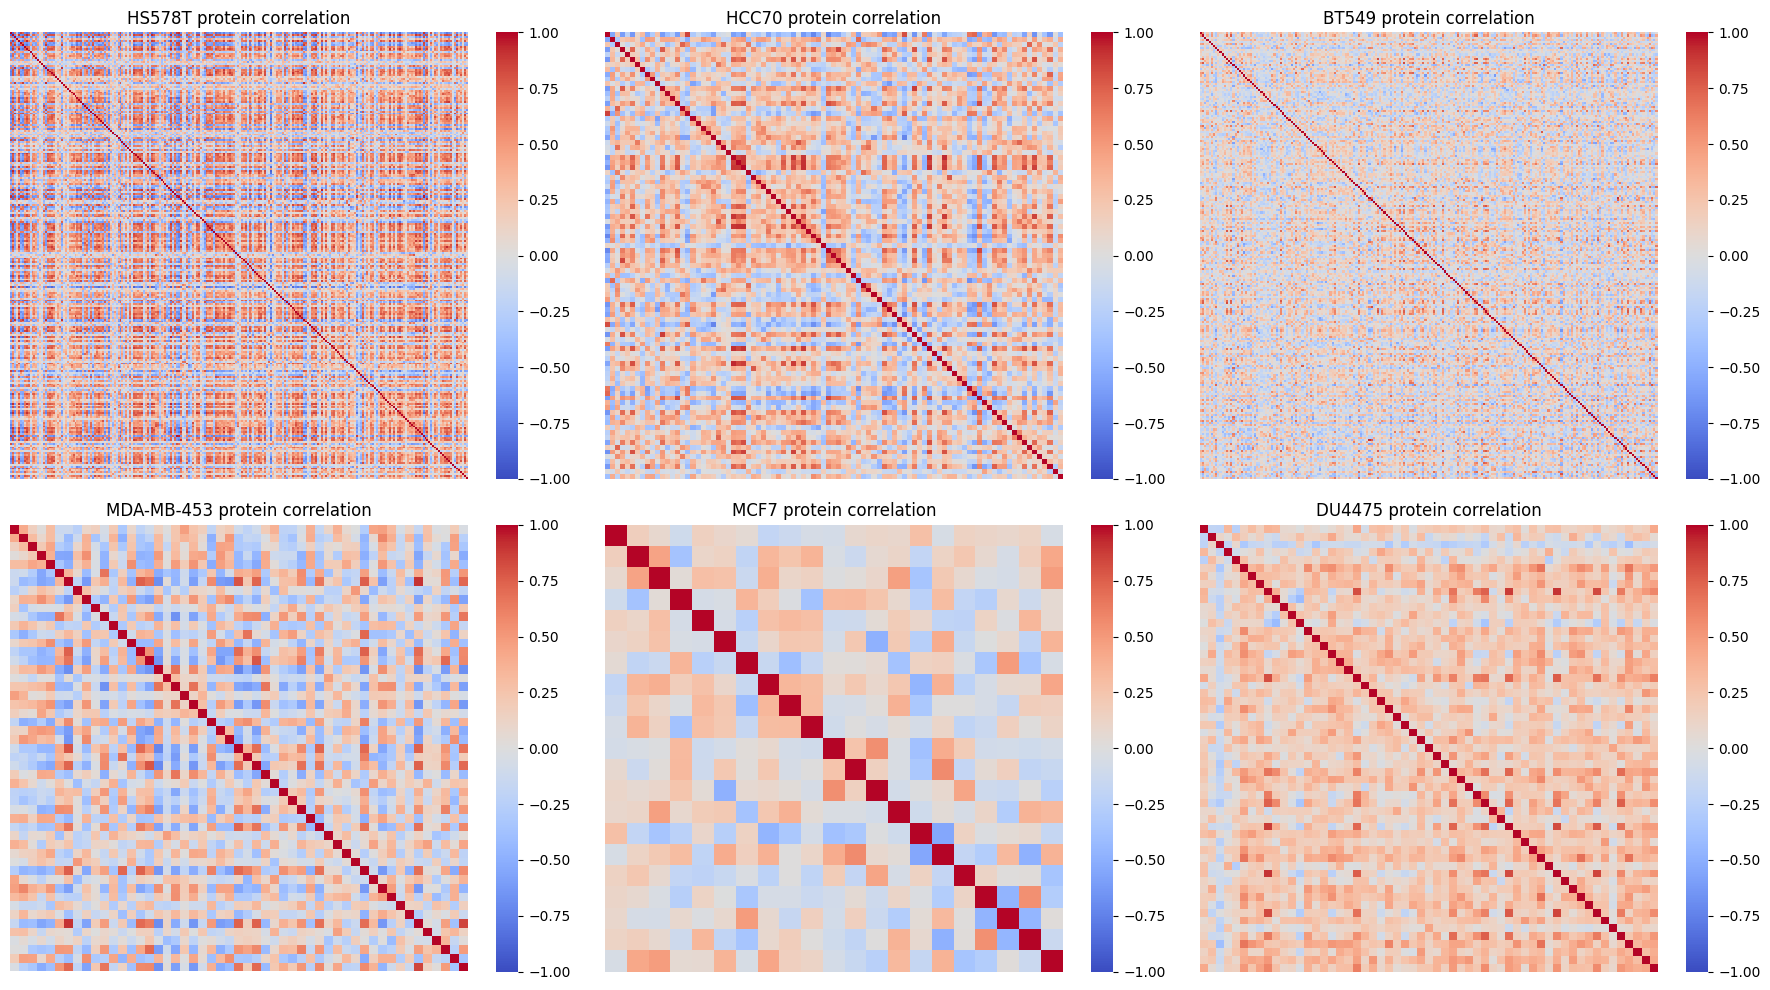

In [6]:
#48hr pipeline:
print('targeted proteins 48hr')
forty_eight_hr_tgt_pipeline=filtering_pipeline(targeted_prots_raw_48hr,data_48hr['cell_lines'],data_48hr['control_data_by_cell_line'],'48hr',data_48hr['control_data_by_cell_line_coeffvar'],**config)
hd_fortyeight_tgt=forty_eight_hr_tgt_pipeline.run_pipeline(pipeline_steps_tgt)
sum_fortyeight_tgt=forty_eight_hr_tgt_pipeline.summary_of_pipeline()
forty_eight_hr_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='tgt')

print('non-targeted proteins 48hr')
forty_eight_hr_non_tgt_pipeline=filtering_pipeline(non_targeted_prots_raw_48hr,data_48hr['cell_lines'],data_48hr['control_data_by_cell_line'],'48hr',data_48hr['control_data_by_cell_line_coeffvar'],**config)
hd_fortyeight_non_tgt=forty_eight_hr_non_tgt_pipeline.run_pipeline(pipeline_steps_nontgt)
sum_fortyeight_non_tgt=forty_eight_hr_non_tgt_pipeline.summary_of_pipeline()
forty_eight_hr_non_tgt_pipeline.save_pipeline(saved_filter_dir,tgt='nontgt')

loo_results = loo_regression_per_cell_line(
    data_by_cell_line=forty_eight_hr_non_tgt_pipeline.final_filtered_data,
    cell_lines=cell_lines,
    ycol='meta_Inhi_5',
    model=elasticnet_model,
    print_stats=True,
    plot_results=True,
    show_progress=True)

plot_protein_correlation_heatmaps(forty_eight_hr_tgt_pipeline.final_filtered_data,cell_lines)
plot_protein_correlation_heatmaps(forty_eight_hr_non_tgt_pipeline.final_filtered_data,cell_lines)

In [ ]:
#making combined dicts and ablation studying to get the most important so that I can have 100 nodes:
#ablation studying:
#TODO reimpleent the ablation study


#make the combined dictionaries,
combined_6hr_dict,combined_24hr_dict,combined_48hr_dict={},{},{}
for cell in six_hr_non_tgt_pipeline.final_filtered_data.keys():
    combined_6hr_dict[cell]=pd.concat([six_hr_tgt_pipeline.final_filtered_data[cell],six_hr_non_tgt_pipeline.final_filtered_data[cell]],axis=1)
    combined_24hr_dict[cell]=pd.concat([twenty_four_hr_tgt_pipeline.final_filtered_data[cell],twenty_four_hr_non_tgt_pipeline.final_filtered_data[cell]],axis=1)
    combined_48hr_dict[cell]=pd.concat([forty_eight_hr_tgt_pipeline.final_filtered_data[cell],forty_eight_hr_non_tgt_pipeline.final_filtered_data[cell]],axis=1)


#now make cellbox files for each of the timepoints:
#cellbox files look like:
#node_Index, a list of the names of each of the nodes
#pert.csv has all the experiments as rows, and proteins/nodes as columns; expressions zeroed out and the activities are tanh transformed;
#expr.csv has all the experiments as rows, and proteins/nodes as columns; expressions are log2 transformed and activites are tanh transformed









In [12]:
# Calculate overlap statistics for targeted, untargeted, and all proteins
import pandas as pd

def get_protein_columns(df):
    """Return set of columns that are not metadata (do not start with 'meta_')."""
    return set([col for col in df.columns if not col.startswith('meta_')])

stats_tgt = []
stats_nontgt = []
stats_all = []

for cell in cell_lines:
    # Targeted proteins (remove metadata columns)
    prots_6_tgt = get_protein_columns(six_hr_tgt_pipeline.final_filtered_data[cell])
    prots_24_tgt = get_protein_columns(twenty_four_hr_tgt_pipeline.final_filtered_data[cell])
    prots_48_tgt = get_protein_columns(forty_eight_hr_tgt_pipeline.final_filtered_data[cell])
    
    # Untargeted proteins (remove metadata columns)
    prots_6_nontgt = get_protein_columns(six_hr_non_tgt_pipeline.final_filtered_data[cell])
    prots_24_nontgt = get_protein_columns(twenty_four_hr_non_tgt_pipeline.final_filtered_data[cell])
    prots_48_nontgt = get_protein_columns(forty_eight_hr_non_tgt_pipeline.final_filtered_data[cell])
    
    # All proteins (union of targeted and untargeted, after removing metadata)
    prots_6_all = prots_6_tgt | prots_6_nontgt
    prots_24_all = prots_24_tgt | prots_24_nontgt
    prots_48_all = prots_48_tgt | prots_48_nontgt

    # Targeted stats
    stats_tgt.append({
        'Cell Line': cell,
        '6hr': len(prots_6_tgt),
        '24hr': len(prots_24_tgt),
        '48hr': len(prots_48_tgt),
        '6hr∩24hr': len(prots_6_tgt & prots_24_tgt),
        '6hr∩48hr': len(prots_6_tgt & prots_48_tgt),
        '24hr∩48hr': len(prots_24_tgt & prots_48_tgt),
        '6hr∩24hr∩48hr': len(prots_6_tgt & prots_24_tgt & prots_48_tgt)
    })
    # Untargeted stats
    stats_nontgt.append({
        'Cell Line': cell,
        '6hr': len(prots_6_nontgt),
        '24hr': len(prots_24_nontgt),
        '48hr': len(prots_48_nontgt),
        '6hr∩24hr': len(prots_6_nontgt & prots_24_nontgt),
        '6hr∩48hr': len(prots_6_nontgt & prots_48_nontgt),
        '24hr∩48hr': len(prots_24_nontgt & prots_48_nontgt),
        '6hr∩24hr∩48hr': len(prots_6_nontgt & prots_24_nontgt & prots_48_nontgt)
    })
    # All proteins stats
    stats_all.append({
        'Cell Line': cell,
        '6hr': len(prots_6_all),
        '24hr': len(prots_24_all),
        '48hr': len(prots_48_all),
        '6hr∩24hr': len(prots_6_all & prots_24_all),
        '6hr∩48hr': len(prots_6_all & prots_48_all),
        '24hr∩48hr': len(prots_24_all & prots_48_all),
        '6hr∩24hr∩48hr': len(prots_6_all & prots_24_all & prots_48_all)
    })

# Display tables
print("Targeted Protein Overlap:")
display(pd.DataFrame(stats_tgt))
print("Untargeted Protein Overlap:")
display(pd.DataFrame(stats_nontgt))
print("All Proteins Overlap:")
display(pd.DataFrame(stats_all))


Targeted Protein Overlap:


,Cell Line,6hr,24hr,48hr,6hr∩24hr,6hr∩48hr,24hr∩48hr,6hr∩24hr∩48hr
0,HS578T,20,21,17,12,9,10,6
1,HCC70,11,18,15,6,7,11,5
2,BT549,21,22,22,11,14,14,8
3,MDA-MB-453,8,12,14,3,4,10,2
4,MCF7,14,16,12,7,7,9,5
5,DU4475,11,13,13,7,6,6,4


Untargeted Protein Overlap:


,Cell Line,6hr,24hr,48hr,6hr∩24hr,6hr∩48hr,24hr∩48hr,6hr∩24hr∩48hr
0,HS578T,134,149,234,14,12,29,4
1,HCC70,75,111,91,3,4,11,1
2,BT549,198,265,212,34,18,42,4
3,MDA-MB-453,75,50,51,20,11,9,4
4,MCF7,15,21,21,0,0,0,0
5,DU4475,27,28,57,3,3,0,0


All Proteins Overlap:


,Cell Line,6hr,24hr,48hr,6hr∩24hr,6hr∩48hr,24hr∩48hr,6hr∩24hr∩48hr
0,HS578T,154,170,251,26,21,39,10
1,HCC70,86,129,106,9,11,22,6
2,BT549,219,287,234,45,32,56,12
3,MDA-MB-453,83,62,65,23,15,19,6
4,MCF7,29,37,33,7,7,9,5
5,DU4475,38,41,70,10,9,6,4


In [ ]:
# legacy timepoint analysis
# Calculate Mutual Information between timepoints for each protein in each cell line
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

# Prepare to collect Mutual Information values per cell line and timepoint pair
mi_by_cell = {
    '6_24': {},
    '24_48': {},
    '6_48': {}
}

cell_lines = data_6hr['cell_lines']
n_cells = len(cell_lines)
n_cols = 3
n_rows = int(np.ceil(n_cells / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

# Color and label settings for each comparison
mi_pairs = [
    ('6_24', log2_transform_6hr, log2_transform_24hr, '#1f77b4', '6hr vs 24hr'),
    ('24_48', log2_transform_24hr, log2_transform_48hr, '#d62728', '24hr vs 48hr'),
    ('6_48', log2_transform_6hr, log2_transform_48hr, '#2ca02c', '6hr vs 48hr')
]

for idx, cell in enumerate(cell_lines):
    ax = axes[idx]
    for pair_key, df_a_dict, df_b_dict, color, label in mi_pairs:
        df_a = df_a_dict[cell]
        df_b = df_b_dict[cell]
        # Find common protein columns (excluding meta columns)
        prot_cols_a = [col for col in df_a.columns if not col.startswith('meta_')]
        prot_cols_b = [col for col in df_b.columns if not col.startswith('meta_')]
        common_prots = sorted(list(set(prot_cols_a) & set(prot_cols_b)))

        print(f"Cell line: {cell} | {label}")
        print(f"  Number of proteins at timepoint A: {len(prot_cols_a)}")
        print(f"  Number of proteins at timepoint B: {len(prot_cols_b)}")
        print(f"  Number of common proteins: {len(common_prots)}")
        if not common_prots:
            mi_by_cell[pair_key][cell] = []
            continue

        # For each protein, compute mutual information between timepoints across all experiments
        mi_scores = []
        for prot in common_prots:
            x = df_a[prot].values
            y = df_b[prot].values
            # Only keep pairs where both are finite
            mask = np.isfinite(x) & np.isfinite(y)
            if np.sum(mask) > 1:
                # Reshape for sklearn
                x_masked = x[mask].reshape(-1, 1)
                y_masked = y[mask]
                # mutual_info_regression expects 2D X and 1D y
                try:
                    mi = mutual_info_regression(x_masked, y_masked, random_state=0)
                    if np.isfinite(mi[0]):
                        mi_scores.append(mi[0])
                except Exception as e:
                    # If MI fails (e.g., constant input), skip
                    pass
        mi_by_cell[pair_key][cell] = mi_scores

        # Plot histogram for this cell line and timepoint pair
        ax.hist(
            mi_scores,
            bins=30,
            color=color,
            alpha=0.45,
            edgecolor='black',
            label=label
        )

    ax.set_xlabel('Mutual Information')
    ax.set_ylabel('Count')
    ax.set_title(f'{cell}\nHistogram of Mutual Information (per protein)')
    ax.grid(alpha=0.2)
    ax.legend()

# Hide unused subplots
for j in range(len(cell_lines), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
#This is legacy code for the 6,24,48hr histgram data;


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba

# Prepare data and cell lines
cell_lines = data_48hr['cell_lines']

# Use more distinct, custom colors and higher transparency for overlap clarity
timepoint_colors = {
    '6hr': to_rgba('#1f77b4', alpha=0.35),    # blue, more transparent
    '24hr': to_rgba('#d62728', alpha=0.35),   # red, more transparent
    '48hr': to_rgba('#2ca02c', alpha=0.35)    # green, more transparent
}
timepoint_labels = {
    '6hr': '6 hr',
    '24hr': '24 hr',
    '48hr': '48 hr'
}
timepoint_data = {
    '6hr': log2_transform_6hr,
    '24hr': log2_transform_24hr,
    '48hr': log2_transform_48hr
}

n_cols = 3
n_rows = int(np.ceil(len(cell_lines) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

for idx, cell in enumerate(cell_lines):
    ax = axes[idx]
    for tp, color in timepoint_colors.items():
        # Drop meta columns and flatten values
        meta_cols = timepoint_data[tp][cell].filter(regex='meta_').columns
        vals = timepoint_data[tp][cell].drop(columns=meta_cols).select_dtypes(include=[float, int]).values.flatten()
        vals = vals[~np.isnan(vals)]
        ax.hist(
            vals,
            bins=100,
            alpha=.33,  # alpha handled in color
            color=color,
            label=timepoint_labels[tp],
            log=False,
            edgecolor='none'
        )
    ax.set_title(f"{cell} - Data Value Distribution")
    ax.set_xlabel("log2(fold change)")
    ax.set_ylabel("Count (log scale)")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(len(cell_lines), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


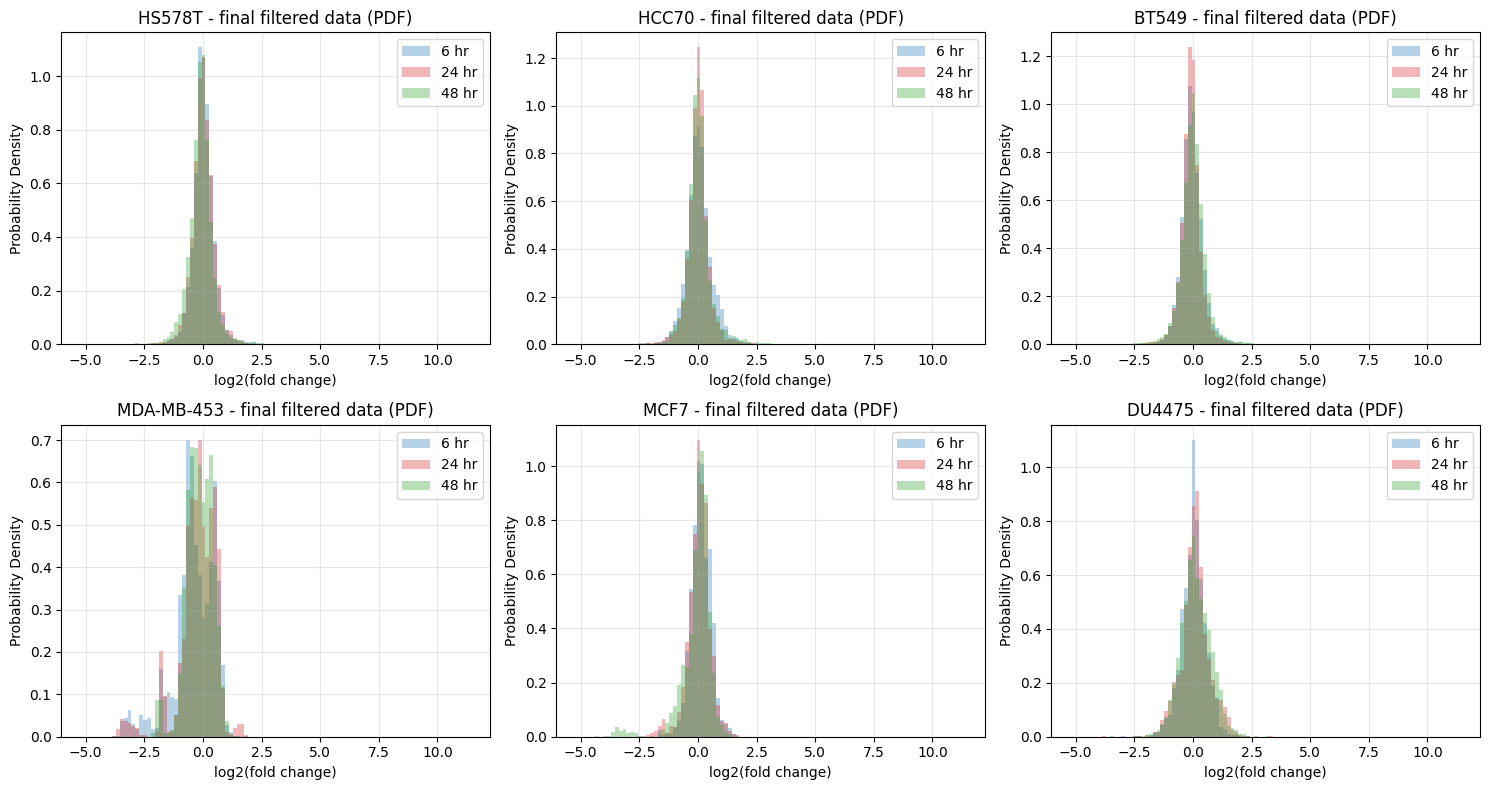

In [17]:
# Plot post-filtering 6,24,48hr probability density functions (PDFs) using the combined data_dicts:
# The dictionaries of data are the combined dicts:
# combined_6hr_dict, combined_24hr_dict, combined_48hr_dict

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba

# Prepare data and cell lines
cell_lines = list(combined_6hr_dict.keys())

# Use more distinct, custom colors and higher transparency for overlap clarity
timepoint_colors = {
    '6hr': to_rgba('#1f77b4', alpha=0.35),    # blue, more transparent
    '24hr': to_rgba('#d62728', alpha=0.35),   # red, more transparent
    '48hr': to_rgba('#2ca02c', alpha=0.35)    # green, more transparent
}
timepoint_labels = {
    '6hr': '6 hr',
    '24hr': '24 hr',
    '48hr': '48 hr'
}
timepoint_data = {
    '6hr': combined_6hr_dict,
    '24hr': combined_24hr_dict,
    '48hr': combined_48hr_dict
}

n_cols = 3
n_rows = int(np.ceil(len(cell_lines) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

# To ensure all PDFs are on the same x-axis, find global min/max
all_vals = []
for tp in timepoint_data:
    for cell in cell_lines:
        df = timepoint_data[tp][cell]
        meta_cols = df.filter(regex='meta_').columns
        vals = df.drop(columns=meta_cols).select_dtypes(include=[float, int]).values.flatten()
        vals = vals[~np.isnan(vals)]
        all_vals.append(vals)
all_vals = np.concatenate(all_vals)
x_min, x_max = np.min(all_vals), np.max(all_vals)
bins = np.linspace(x_min, x_max, 101)  # 100 bins

#plotting
for idx, cell in enumerate(cell_lines):
    ax = axes[idx]
    for tp, color in timepoint_colors.items():
        # Drop meta columns and flatten values
        df = timepoint_data[tp][cell]
        meta_cols = df.filter(regex='meta_').columns
        vals = df.drop(columns=meta_cols).select_dtypes(include=[float, int]).values.flatten()
        vals = vals[~np.isnan(vals)]
        # Plot PDF: density=True ensures area under curve sums to 1
        ax.hist(
            vals,
            bins=bins,
            alpha=.33,  # alpha handled in color
            color=color,
            label=timepoint_labels[tp],
            log=False,
            edgecolor='none',
            density=True
        )
    ax.set_title(f"{cell} - final filtered data (PDF)")
    ax.set_xlabel("log2(fold change)")
    ax.set_ylabel("Probability Density")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(len(cell_lines), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


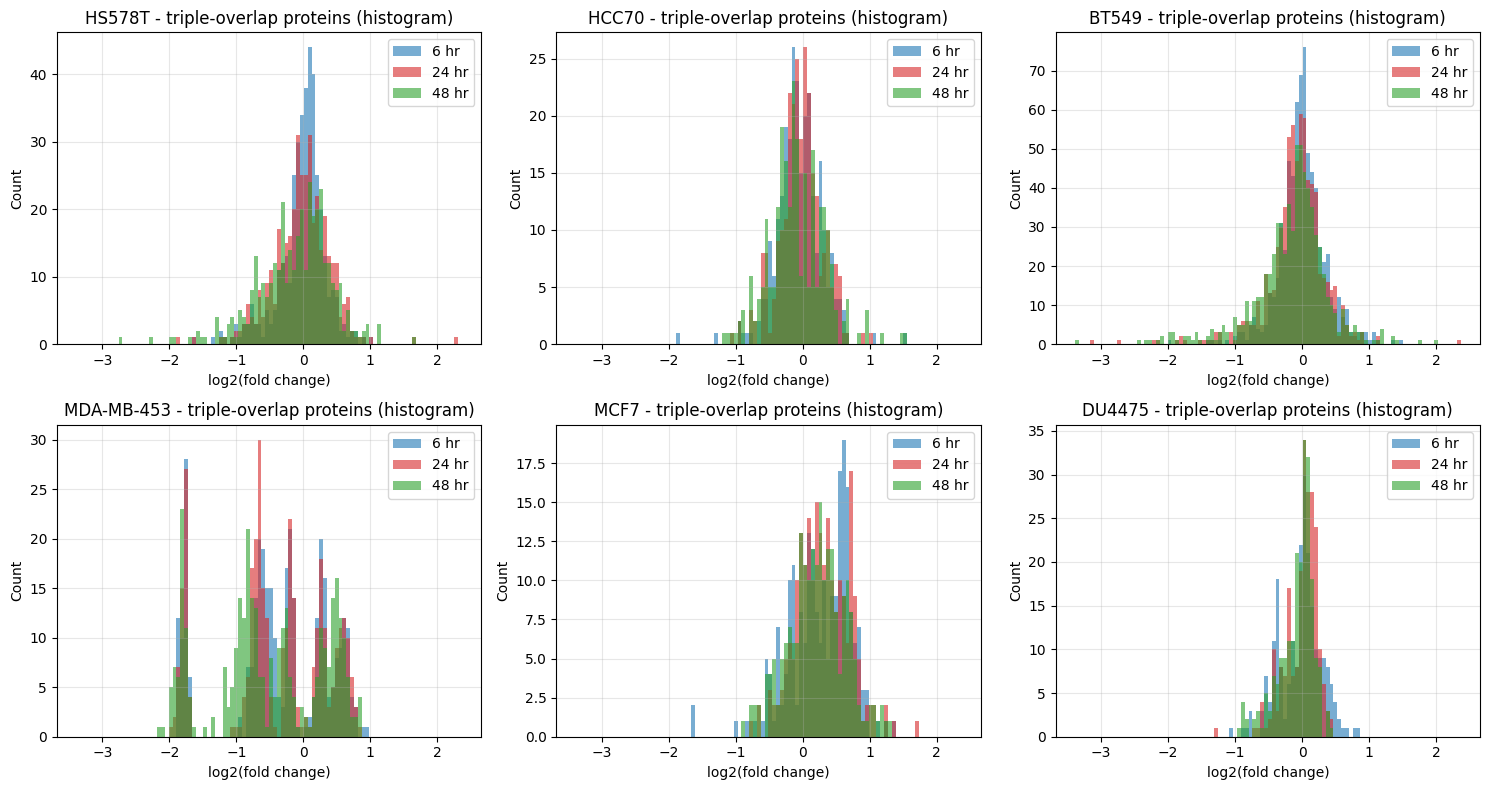

In [20]:
# Plot histograms (not PDFs) of triple-overlap proteins for 6, 24, and 48 hr timepoints

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

def get_protein_columns(df):
    """Return set of columns that are not metadata (do not start with 'meta_')."""
    return set([col for col in df.columns if not col.startswith('meta_')])

# Prepare data and cell lines
cell_lines = list(combined_6hr_dict.keys())

# For each cell line, find the triple-overlap proteins (present in all 3 timepoints)
triple_overlap_proteins = {}
for cell in cell_lines:
    prots_6 = get_protein_columns(combined_6hr_dict[cell])
    prots_24 = get_protein_columns(combined_24hr_dict[cell])
    prots_48 = get_protein_columns(combined_48hr_dict[cell])
    triple_overlap_proteins[cell] = prots_6 & prots_24 & prots_48

# Set up colors and labels for timepoints
timepoint_colors = {
    '6hr': to_rgba('#1f77b4', alpha=0.6),    # blue
    '24hr': to_rgba('#d62728', alpha=0.6),   # red
    '48hr': to_rgba('#2ca02c', alpha=0.6)    # green
}
timepoint_labels = {
    '6hr': '6 hr',
    '24hr': '24 hr',
    '48hr': '48 hr'
}
timepoint_data = {
    '6hr': combined_6hr_dict,
    '24hr': combined_24hr_dict,
    '48hr': combined_48hr_dict
}

# For consistent binning, collect all values for triple-overlap proteins across all cell lines and timepoints
all_vals = []
for tp in ['6hr', '24hr', '48hr']:
    for cell in cell_lines:
        prots = triple_overlap_proteins[cell]
        if len(prots) == 0:
            continue
        df = timepoint_data[tp][cell]
        vals = df[list(prots)].select_dtypes(include=[float, int]).values.flatten()
        vals = vals[~np.isnan(vals)]
        all_vals.append(vals)
if len(all_vals) > 0:
    all_vals = np.concatenate(all_vals)
    x_min, x_max = np.min(all_vals), np.max(all_vals)
else:
    x_min, x_max = -1, 1  # fallback

bins = np.linspace(x_min, x_max, 101)  # 100 bins

# Plot histograms for each cell line
n_cols = 3
n_rows = int(np.ceil(len(cell_lines) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
axes = axes.flatten()

for idx, cell in enumerate(cell_lines):
    ax = axes[idx]
    prots = triple_overlap_proteins[cell]
    if len(prots) == 0:
        ax.set_title(f"{cell} (no triple-overlap proteins)")
        ax.axis('off')
        continue
    for tp, color in timepoint_colors.items():
        df = timepoint_data[tp][cell]
        vals = df[list(prots)].select_dtypes(include=[float, int]).values.flatten()
        vals = vals[~np.isnan(vals)]
        ax.hist(
            vals,
            bins=bins,
            alpha=0.6,
            color=color,
            label=timepoint_labels[tp],
            log=False,
            edgecolor='none',
            density=False  # Not a PDF, just counts
        )
    ax.set_title(f"{cell} - triple-overlap proteins (histogram)")
    ax.set_xlabel("log2(fold change)")
    ax.set_ylabel("Count")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(len(cell_lines), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Targeted proteins pipeline

In [ ]:
#//////////////////plot the distribution before and after filtering/////////////////
config={'graph_type':'hist','bins':100,'meanandstd':True}
before=plot_data_value_distribution(step_2_tgtd_prots, cell_lines, **config)
after=plot_data_value_distribution(final_filtered_tgtd_prots, cell_lines, **config)



In [ ]:
#///////////////////////Exploratory analysis/////////////////////


#graphing filters by each other, note this is broken for incomplete experiments (since it doesnt operate on proteins) 
#and for remove outlier since it calculates the threshold internally
a_config2 = {
    'graph_flag': False,'print_flag': True,'graph_type': 'hist','filter_flag': True, 'verbose':True }
kwargs={'xlabel':'mutual information','ylabel':'pearson corr'}
fxnargs1={'mi thresh':.001,'threshold':.001,'y_col':'meta_Inhi_5'}
fxnargs2={'threshold':.001,'y_col':'meta_Inhi_5'}
fxnargs1,fxnargs2={**a_config2,**fxnargs1},{**a_config2,**fxnargs2}
x=filterAbyfilterB(filter_by_mutual_information,pearson_corr_filtering,step_6_tgtd_prots,cell_lines,fxnargs1,fxnargs2,**kwargs)

# Non-targeted proteins

In [ ]:
#//////////////////plot the distribution before and after filtering/////////////////
config={'graph_type':'hist','bins':100,'meanandstd':True}
before=plot_data_value_distribution(step_2_non_tgt, cell_lines, **config)
after=plot_data_value_distribution(final_filtered_non_tgt_prots, cell_lines, **config)

In [ ]:
#///////////////////////Exploratory analysis/////////////////////


#graphing filters by each other, note this is broken for incomplete experiments (since it doesnt operate on proteins) 
#and for remove outlier since it calculates the threshold internally
a_config2 = {
    'graph_flag': False,'print_flag': True,'graph_type': 'hist','filter_flag': True, 'verbose':True }
kwargs={'xlabel':'mutual information','ylabel':'pearson corr'}
fxnargs1={'mi_thresh':.05,'threshold':.05,'y_col':'meta_Inhi_5'}
fxnargs2={'threshold':.2,'ycol':'meta_Inhi_5'}
fxnargs1,fxnargs2={**a_config2,**fxnargs1},{**a_config2,**fxnargs2}
x=filterAbyfilterB(filter_by_mutual_information,pearson_corr_filtering,step_6_non_tgt,cell_lines,fxnargs1,fxnargs2,**kwargs)

In [ ]:
#ablation study selection use for the last 200ish proteins;
#cant use because we seem to lack correlation between the cell viability and the proteins.
#have to go back and re-assess the mutual information choice
overlaps={}
overlaps_full_data={}
for i, cell_line in enumerate(cell_lines):
    print(f"Processing cell line: {cell_line}")
    starting_data=final_filtered_non_tgt_prots[cell_line]
    nfeatures=int(100-len(final_filtered_tgtd_prots[cell_line].columns))
    topx_prots=ablation_study(starting_data,
    model='ElasticNet',
    n_features_to_select=nfeatures,
    target_column='meta_Inhi_5',
    verbosity=1
    )
    overlaps[cell_line],overlaps_full_data[cell_line]=overlapping_features(topx_prots,n_prots_to_keep=nfeatures)
    print("\n\n\n")



In [ ]:
#making the final dictionaries of the data:
#add in the proteins named in overlaps[cell_line] (and get data from the non-targeted data) and then add in targeted proteins
#and then preserve viability data
top_100_proteins={}
for cell_line in cell_lines:
    non_tgts=filtered_non_targeted_prots_by_spearman[cell_line].loc[:,overlaps[cell_line]]
    tgts=filtered_targeted_prots[cell_line]
    meta_data=meta_preserved_d3[cell_line][['pert_id','trial names']]
    top_100_proteins[cell_line]=pd.concat([non_tgts,tgts,meta_data],axis=1)


a_test=top_100_proteins[cell_lines[0]]

In [ ]:
sensitive_cell_lines=['HS578T','HCC70','BT549']
for cell_line in sensitive_cell_lines:
    df = top_100_proteins[cell_line]
    output_path = Path(f"{cell_line}_top_100_data.csv")
    df.to_csv(output_path, sep=",")
    print(f"Saved sensitive cell line data for {cell_line} to {output_path}")

In [ ]:
# Plot histograms of data value distribution and column variance for each sensitive cell line

for cell_line in sensitive_cell_lines:
    df = top_100_proteins[cell_line].drop(columns=['pert_id','trial names','Inhi_5'])
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Histogram of all data values
    data_values = df.values.flatten()
    mean_data = data_values.mean()
    axes[0].hist(data_values, bins=100, color="#3182bd", alpha=0.8)
    axes[0].axvline(mean_data, color='red', linestyle='dashed', linewidth=2, label=f"Mean = {mean_data:.2f}")
    axes[0].set_title(f"{cell_line} - Protein value Distribution")
    axes[0].set_xlabel("Protein expression (log2 normalized)")
    axes[0].set_ylabel("Count")
    axes[0].legend()
    
    # Histogram of variance of each column (experiment)
    col_vars = df.var(axis=0)
    mean_var = col_vars.mean()
    axes[1].hist(col_vars, bins=50, color="#e6550d", alpha=0.8)
    axes[1].axvline(mean_var, color='blue', linestyle='dashed', linewidth=2, label=f"Mean = {mean_var:.2f}")
    axes[1].set_title(f"{cell_line} - Protein Variance ")
    axes[1].set_xlabel("Variance")
    axes[1].set_ylabel("Protein count")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


In [ ]:
#making cellbox files for the sensitive cell lines:
df=pd.read_csv(
    r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\preprocessing\Intermediate_files\HS578T_top_100_data.csv'
)
df.head()

pert_ids = df['trial names'].apply(lambda x: x.split('_')[0])
# Get the targeted proteins by pulling up all values stored under the pert Ids
overall_tgtd_prots = list(pert_ids.map(drug_pert_id_targets_dict).explode().unique())
overlaps=list(set(overall_tgtd_prots).intersection(set(df.columns)))

acti=df.copy()
acti[~acti.columns.isin(overlaps)]=0












### Legacy

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

plt.clf()
fig, axes = plt.subplots(len(cell_lines), 2, figsize=(10, 4 * len(cell_lines)))

for i, cell_line in enumerate(cell_lines):
    print(f"Processing cell line: {cell_line}")
    df = top_100_proteins[cell_line].copy()
    # Drop rows with missing values
    df = df.dropna()
    # Features: all protein columns (exclude 'pert_id', 'trial names', and target)
    feature_cols = [col for col in df.columns if col not in ['pert_id', 'trial names', 'Inhi_5']]
    if 'Inhi_5' not in df.columns:
        print(f"Skipping {cell_line}: 'Inhi_5' not found.")
        continue
    X = df[feature_cols].values
    y = df['Inhi_5'].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit ElasticNet
    # Scan through different alphas and l1_ratios to find the best combination using grid search
    from sklearn.model_selection import GridSearchCV

    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    base_model = ElasticNet(random_state=42, max_iter=10000)
    grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    pearson_train = pearsonr(y_train, y_train_pred)[0]
    pearson_test = pearsonr(y_test, y_test_pred)[0]

    # Plot train
    ax_train = axes[i, 0] if len(cell_lines) > 1 else axes[0]
    ax_train.scatter(y_train, y_train_pred, alpha=0.7, color="#2b8cbe")
    ax_train.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    ax_train.set_title(f"{cell_line} - Train\nR2={r2_train:.3f}, Pearson={pearson_train:.3f}, MSE={mse_train:.4f}")
    ax_train.set_xlabel("Actual Inhi_5")
    ax_train.set_ylabel("Predicted Inhi_5")

    # Plot test
    ax_test = axes[i, 1] if len(cell_lines) > 1 else axes[1]
    ax_test.scatter(y_test, y_test_pred, alpha=0.7, color="#e34a33")
    ax_test.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax_test.set_title(f"{cell_line} - Test\nR2={r2_test:.3f}, Pearson={pearson_test:.3f}, MSE={mse_test:.4f}")
    ax_test.set_xlabel("Actual Inhi_5")
    ax_test.set_ylabel("Predicted Inhi_5")

plt.tight_layout()
plt.show()
